In [1]:
import pandas as pd
import pyarrow.dataset as pads
import os
import numpy as np
pd.set_option('display.max_columns', None)

data_path = "/Users/alexfrederick/Desktop/SMT-Data-Challenge-2025/"

In [2]:
def readDataSubset(table_type, data_path):
    """
    Loads a specified SMT data subset as a PyArrow dataset.
    """
    valid_tables = ['ball_pos', 'game_events', 'game_info', 'player_pos', 'rosters']
    if table_type not in valid_tables:
        print("Invalid data subset name. Please try again with a valid data subset.")
        return None

    if table_type == 'rosters':
        return pads.dataset(source=os.path.join(data_path, 'rosters.csv'), format='csv')
    else:
        
        return pads.dataset(
            source=os.path.join(data_path, table_type),
            format='csv'
        )

In [3]:
game_info_ds = readDataSubset('game_info', data_path)
game_events_ds = readDataSubset('game_events', data_path)
ball_pos_ds = readDataSubset('ball_pos', data_path)
player_pos_ds = readDataSubset('player_pos', data_path)
rosters_ds = readDataSubset('rosters', data_path)

In [4]:
import pyarrow as pa

filter_criteria = (
    (pads.field("home_team") == "QEA")
)

import pandas as pd
import glob

# Define where your game_info CSVs are stored
game_info_path = "/Users/alexfrederick/Desktop/SMT-Data-Challenge-2025/game_info"
csv_files = glob.glob(f"{game_info_path}/**/*.csv", recursive=True)

# Specify null indicators
na_values = ["", "NA", "NULL", "\\N"]

# Load all CSVs safely using pandas
game_info_df = pd.concat(
    [pd.read_csv(f, na_values=na_values) for f in csv_files],
    ignore_index=True
)

game_events_df = game_events_ds.to_table().to_pandas()

In [5]:
game_info_df

,game_str,home_team,away_team,at_bat,play_per_game,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner
0,y1_d081_FBP_QEA,QEA,FBP,1.0,1.0,top,QEA-0394,QEA-0218,QEA-0263,QEA-0365,QEA-0277,QEA-0027,QEA-0364,QEA-0421,QEA-0249,FBP-1349,NaN,NaN,NaN
1,y1_d081_FBP_QEA,QEA,FBP,1.0,2.0,top,QEA-0394,QEA-0218,QEA-0263,QEA-0365,QEA-0277,QEA-0027,QEA-0364,QEA-0421,QEA-0249,FBP-1349,NaN,NaN,NaN
2,y1_d081_FBP_QEA,QEA,FBP,1.0,3.0,top,QEA-0394,QEA-0218,QEA-0263,QEA-0365,QEA-0277,QEA-0027,QEA-0364,QEA-0421,QEA-0249,FBP-1349,NaN,NaN,NaN
3,y1_d081_FBP_QEA,QEA,FBP,1.0,4.0,top,QEA-0394,QEA-0218,QEA-0263,QEA-0365,QEA-0277,QEA-0027,QEA-0364,QEA-0421,QEA-0249,FBP-1349,NaN,NaN,NaN
4,y1_d081_FBP_QEA,QEA,FBP,2.0,5.0,top,QEA-0394,QEA-0218,QEA-0263,QEA-0365,QEA-0277,QEA-0027,QEA-0364,QEA-0421,QEA-0249,FBP-1154,NaN,FBP-1349,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72561,y1_d074_PHS_RZQ,RZQ,PHS,NaN,257.0,top,RZQ-0044,RZQ-0059,RZQ-0333,RZQ-0347,RZQ-0258,RZQ-0287,RZQ-0014,RZQ-0274,RZQ-0214,PHS-1928,NaN,NaN,NaN
72562,y1_d074_PHS_RZQ,RZQ,PHS,NaN,258.0,top,RZQ-0044,RZQ-0059,RZQ-0333,RZQ-0347,RZQ-0258,RZQ-0287,RZQ-0014,RZQ-0274,RZQ-0214,PHS-1359,NaN,NaN,NaN
72563,y1_d074_PHS_RZQ,RZQ,PHS,NaN,259.0,top,RZQ-0044,RZQ-0059,RZQ-0333,RZQ-0347,RZQ-0258,RZQ-0287,RZQ-0014,RZQ-0274,RZQ-0214,PHS-1359,NaN,NaN,NaN
72564,y1_d074_PHS_RZQ,RZQ,PHS,NaN,260.0,top,RZQ-0044,RZQ-0059,RZQ-0333,RZQ-0347,RZQ-0258,RZQ-0287,RZQ-0014,RZQ-0274,RZQ-0214,PHS-1359,NaN,NaN,NaN


In [6]:
# some keys
position_key = pd.DataFrame({
    "code": [*range(1, 14), 255, 14, 15, 16, 17, 18, 19],
    "position": [
        "pitcher", "catcher", "first baseman", "second baseman", "third baseman",
        "shortstop", "left field", "center field", "right field", "batter",
        "runner on first base", "runner on second base", "runner on third base",
        "ball event with no player (e.g., ball bounce)", "home plate umpire",
        "field umpire", "field umpire", "field umpire",
        "first base coach", "third base coach"
    ]
})

event_key = pd.DataFrame({
    "code": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 16],
    "play_type": [
        "pitch", "ball acquired", "throw (ball-in-play)", "ball hit into play", 
        "end of play", "pickoff throw", "ball acquired - unknown field position", 
        "throw (ball-in-play) - unknown field position", "ball deflection", 
        "ball deflection off of wall", "home run", "ball bounce"
    ]
})

In [7]:
import pandas as pd

big_ie = pd.merge(
    game_events_df, 
    game_info_df, 
    on=['game_str', 'play_per_game'], 
    suffixes=('', '_dup')
)

big_ie = big_ie.loc[:, ~big_ie.columns.str.endswith('_dup')]

big_ie['player_position'] = pd.to_numeric(big_ie['player_position'], errors='coerce').astype('Int64')
big_ie['event_code'] = pd.to_numeric(big_ie['event_code'], errors='coerce').astype('Int64')

big_ie = big_ie.merge(position_key, how='left', left_on='player_position', right_on='code').drop('code', axis=1)

big_ie = big_ie.merge(event_key, how='left', left_on='event_code', right_on='code').drop('code', axis=1)

big_ie

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,pitcher,pitch
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,catcher,ball acquired
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,pitcher,pitch
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,catcher,ball acquired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273772,y1_d058_WZR_YJD,330,93,330,12027662,255,16,YJD,WZR,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1942,WZR-1285,NaN,NaN,"ball event with no player (e.g., ball bounce)",ball bounce
273773,y1_d058_WZR_YJD,330,93,330,12027959,255,16,YJD,WZR,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1942,WZR-1285,NaN,NaN,"ball event with no player (e.g., ball bounce)",ball bounce
273774,y1_d058_WZR_YJD,330,93,330,12029972,8,2,YJD,WZR,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1942,WZR-1285,NaN,NaN,center field,ball acquired
273775,y1_d058_WZR_YJD,330,93,330,12031028,8,3,YJD,WZR,top,YJD-0157,YJD-0007,YJD-0373,YJD-0060,YJD-0284,YJD-0172,YJD-0398,YJD-0185,YJD-0340,WZR-1942,WZR-1285,NaN,NaN,center field,throw (ball-in-play)


In [8]:
small_ie = big_ie.get(['game_str', 'play_id', 'at_bat', 'play_per_game', 'event_code', 'top_bottom_inning', 'first_baserunner', 'second_baserunner', 'third_baserunner', 'play_type'])
small_ie

,game_str,play_id,at_bat,play_per_game,event_code,top_bottom_inning,first_baserunner,second_baserunner,third_baserunner,play_type
0,y1_d069_ACN_QEA,1,1,1,1,top,NaN,NaN,NaN,pitch
1,y1_d069_ACN_QEA,1,1,1,2,top,NaN,NaN,NaN,ball acquired
2,y1_d069_ACN_QEA,1,1,1,5,top,NaN,NaN,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,1,top,NaN,NaN,NaN,pitch
4,y1_d069_ACN_QEA,2,1,2,2,top,NaN,NaN,NaN,ball acquired
...,...,...,...,...,...,...,...,...,...,...
273772,y1_d058_WZR_YJD,330,93,330,16,top,WZR-1285,NaN,NaN,ball bounce
273773,y1_d058_WZR_YJD,330,93,330,16,top,WZR-1285,NaN,NaN,ball bounce
273774,y1_d058_WZR_YJD,330,93,330,2,top,WZR-1285,NaN,NaN,ball acquired
273775,y1_d058_WZR_YJD,330,93,330,3,top,WZR-1285,NaN,NaN,throw (ball-in-play)


## Fix at bat col

In [9]:
at_bat = list()
game_info_df_sub = big_ie[big_ie['at_bat'].notna()]
for row in range(len(game_info_df_sub)):
    if row==0:
        at_bat = at_bat + [1]
    elif game_info_df_sub.loc[row, 'game_str'] != game_info_df_sub.loc[row-1, 'game_str']:
        at_bat = at_bat + [1]
    elif game_info_df_sub.loc[row, 'batter'] == game_info_df_sub.loc[row-1, 'batter']:
        at_bat = at_bat + [at_bat[row-1]]
    else:
        at_bat = at_bat + [at_bat[row-1] + 1]

In [10]:
game_info_df_sub['at_bat'] = at_bat
final_ie = game_info_df_sub
final_ie.head(25)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type
0,y1_d069_ACN_QEA,1,1,1,14853,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,pitcher,pitch
1,y1_d069_ACN_QEA,1,1,1,15303,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,catcher,ball acquired
2,y1_d069_ACN_QEA,1,1,1,15303,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,NaN,end of play
3,y1_d069_ACN_QEA,2,1,2,27753,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,pitcher,pitch
4,y1_d069_ACN_QEA,2,1,2,28253,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,catcher,ball acquired
5,y1_d069_ACN_QEA,2,1,2,28253,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,NaN,end of play
6,y1_d069_ACN_QEA,3,1,3,42003,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,pitcher,pitch
7,y1_d069_ACN_QEA,3,1,3,42503,2,2,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,catcher,ball acquired
8,y1_d069_ACN_QEA,3,1,3,42503,0,5,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-2455,NaN,NaN,NaN,NaN,end of play
9,y1_d069_ACN_QEA,4,2,4,57303,1,1,QEA,ACN,top,QEA-0410,QEA-0071,QEA-0263,QEA-0277,QEA-0232,QEA-0027,QEA-0364,QEA-0365,QEA-0249,ACN-1416,NaN,NaN,NaN,pitcher,pitch


---
calculate outs and assign them to a new column

In [11]:
value_counts = final_ie['play_type'].value_counts(dropna=False)
value_counts

play_type
end of play                                      71684
pitch                                            71227
ball acquired                                    69108
ball bounce                                      24500
ball hit into play                               24220
throw (ball-in-play)                              9298
pickoff throw                                     1335
ball deflection                                   1183
ball deflection off of wall                        732
home run                                           437
ball acquired - unknown field position              50
throw (ball-in-play) - unknown field position        3
Name: count, dtype: int64

Trying to get ballpark estimate for how many outs we should have that I can then factcheck with the is_out column's sum

make a better foolproof idea for how many outs there should be based on innings. maybe when it changes from top to bottom while at bat changes and mult by 3 and add a constant?

In [12]:
unique_count = (
    final_ie[['game_str', 'batter', 'at_bat']].drop_duplicates().shape[0]
)
unique_count

21936

In [13]:
half_innings_per_game = {}

games = final_ie['game_str'].unique()

for game in games:
    game_df = final_ie[ final_ie['game_str'] == game ]
    
    # sort by timestamp to be in order
    game_df = game_df.sort_values('timestamp')
    
    count = 0
    prev_inning = None
    for current_inning in game_df['top_bottom_inning']:
        # On the very first row, prev_inning is None → count it
        # Thereafter, count whenever the inning value changes
        if prev_inning is None or current_inning != prev_inning:
            count += 1
        prev_inning = current_inning
    
    half_innings_per_game[game] = count

half_innings_per_game = pd.Series(half_innings_per_game)

total_expected_outs = half_innings_per_game.sum() * 3

print("\nTotal expected outs:", total_expected_outs)

half_innings_per_game


Total expected outs: 17121


y1_d069_ACN_QEA       2
y1_d070_ACN_QEA      17
y1_d071_ACN_QEA      17
y1_d072_ACN_QEA      17
y1_d052_APZ_QEA      20
                     ..
y2_d083.5_WMI_YJD    13
y2_d083_WMI_YJD      14
y1_d056_WZR_YJD      17
y1_d057_WZR_YJD      17
y1_d058_WZR_YJD      20
Length: 274, dtype: int64

logic:

skip if home run
1. ball in play and not on base in the next at bat
2. at least 3 pitches in the AB but runner doesn't get on (assume strikeout)
3. pickoff throw and not on base after it
4. fielder's choice getting runner at second, need expand to include third too

likely missing a lot of fielder's choices and obviously the non-force outs

calcs above may be off - think the unique ABs being 22,000 makes sense. then outs being 17000 feels a little high. should be closer to 15000, so logic might be off slightly. it counts all full innings even if maybe walkoff or rain but that shouldnt matter much

In [ ]:
import pandas as pd

def mark_outs_by_event_pattern(df):
    """
    Adds an 'is_out' column based on 4 rules:

    Rule 1: Within a batter’s PA:
      - At least one 'ball hit into play'
      - Batter does NOT end up on base in the first row after the PA

    Rule 2: Within a batter’s PA:
      - At least three 'pitch' entries in play_type
      - Batter does NOT end up on base in the first row after the PA

    Rule 3: On any 'pickoff throw':
      - There is at least one runner on base at that play
      - That runner is gone the next time play_type == 'pitch'

    Rule 4 (NEW): Fielder’s choice at first:
      - play_type == 'ball hit into play' with a runner on first
      - That runner is gone by the next 'pitch'
      - The batter (row['batter']) is on first by that next 'pitch'

    We mark the **last row** of each PA for Rules 1 & 2, the pickoff row for Rule 3, 
    and the ball‑in‑play row for Rule 4.
    """
    df = df.copy()
    df.sort_values(['game_str', 'top_bottom_inning', 'at_bat', 'play_id'], inplace=True)

    # Shifts for Rules 1 & 2
    df['next_first_base']  = df['first_baserunner'].shift(-1)
    df['next_second_base'] = df['second_baserunner'].shift(-1)
    df['next_third_base']  = df['third_baserunner'].shift(-1)

    # placeholders for each rule
    is_out_r1      = pd.Series(False, index=df.index)
    is_out_r3      = pd.Series(False, index=df.index)
    is_out_pickoff = pd.Series(False, index=df.index)
    is_out_fc      = pd.Series(False, index=df.index)  # fielder's choice

    def batter_on_base(next_row, batter):
        return any(
            batter == next_row.get(col)
            for col in ['first_baserunner', 'second_baserunner', 'third_baserunner']
        )

    # RULES 1 & 2: same as before
    for (_, _, _), group in df.groupby(['game_str', 'top_bottom_inning', 'at_bat']):
        if group.empty:
            continue

        seq    = list(group['play_type'])
        if "home run" in seq:
            continue

        idxs   = list(group.index)
        last_i = idxs[-1]
        batter = group['batter'].iloc[0]
        loc    = df.index.get_loc(last_i)

        next_row = df.iloc[loc+1] if loc+1 < len(df) else {}

        # Rule 1
        if "ball hit into play" in seq and not batter_on_base(next_row, batter):
            is_out_r1.at[last_i] = True

        # Rule 2
        if seq.count("pitch") >= 3 and not batter_on_base(next_row, batter):
            is_out_r3.at[last_i] = True

    # RULE 3: pickoff throw
    pickoff_idxs = df.index[df['play_type'] == 'pickoff throw']
    for idx in pickoff_idxs:
        row = df.loc[idx]
        runner_ids = [
            row[col] for col in ['first_baserunner','second_baserunner','third_baserunner']
            if pd.notna(row[col])
        ]
        if not runner_ids:
            continue

        loc = df.index.get_loc(idx)
        subsequent = df.iloc[loc+1:]
        next_pitches = subsequent[subsequent['play_type'] == 'pitch']
        if next_pitches.empty:
            continue

        next_row = next_pitches.iloc[0]
        next_runner_ids = [
            next_row[col] for col in ['first_baserunner','second_baserunner','third_baserunner']
            if pd.notna(next_row[col])
        ]

        if all(r not in next_runner_ids for r in runner_ids):
            is_out_pickoff.at[idx] = True

    # RULE 4: fielder's choice at first
    bip_idxs = df.index[df['play_type'] == 'ball hit into play']
    for idx in bip_idxs:
        row = df.loc[idx]
        original_runner = row['first_baserunner']
        if pd.isna(original_runner):
            continue

        batter = row['batter']
        loc = df.index.get_loc(idx)
        subsequent = df.iloc[loc+1:]
        next_pitches = subsequent[subsequent['play_type'] == 'pitch']
        if next_pitches.empty:
            continue

        next_row = next_pitches.iloc[0]
        # did the original runner disappear?
        next_bases = {
            col: next_row.get(col)
            for col in ['first_baserunner','second_baserunner','third_baserunner']
        }
        runner_gone = all(original_runner != v for v in next_bases.values() if pd.notna(v))
        # is the batter now on first?
        batter_on_1 = (next_row.get('first_baserunner') == batter)

        if runner_gone and batter_on_1:
            is_out_fc.at[idx] = True

    # combine all flags
    df['is_out'] = (
        is_out_r1 | is_out_r3 | is_out_pickoff | is_out_fc
    ).fillna(False)

    return df.drop(columns=['next_first_base', 'next_second_base', 'next_third_base'])


def calculate_outs(df):
    """
    Add a cumulative 'outs' column that resets at each new half-inning,
    counting only when is_out is True.
    """
    df = df.copy()
    df['outs'] = 0
    group_cols = ['game_str', 'top_bottom_inning']

    def count_outs(subdf):
        outs = 0
        outs_list = []
        for is_out in subdf['is_out']:
            if bool(is_out):
                outs += 1
            outs_list.append(outs)
            if outs >= 3:
                outs = 0
        subdf['outs'] = outs_list
        return subdf

    return df.groupby(group_cols, group_keys=False).apply(count_outs)



marked = mark_outs_by_event_pattern(final_ie)
with_outs = calculate_outs(marked).sort_values(['game_str', 'play_id'])
with_outs

/var/folders/xb/jy20y8px72jfxywp5jks_bnc0000gn/T/ipykernel_43992/2847555861.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(count_outs)


,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,position,play_type,is_out,outs
7894,y1_d001_CGA_QEA,1,1,1,8699,1,1,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NaN,NaN,NaN,pitcher,pitch,False,0
7895,y1_d001_CGA_QEA,1,1,1,9199,2,2,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NaN,NaN,NaN,catcher,ball acquired,False,0
7896,y1_d001_CGA_QEA,1,1,1,9199,0,5,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NaN,NaN,NaN,NaN,end of play,False,0
7897,y1_d001_CGA_QEA,2,1,2,24149,1,1,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NaN,NaN,NaN,pitcher,pitch,False,0
7898,y1_d001_CGA_QEA,2,1,2,24599,10,4,QEA,CGA,top,QEA-0110,QEA-0071,QEA-0263,QEA-0365,QEA-0180,QEA-0027,QEA-0249,QEA-0235,QEA-0252,CGA-1458,NaN,NaN,NaN,batter,ball hit into play,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161260,y2_d099_YJD_RZQ,291,78,291,1537052091220,2,2,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NaN,NaN,NaN,catcher,ball acquired,False,2
161261,y2_d099_YJD_RZQ,291,78,291,1537052091220,0,5,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NaN,NaN,NaN,NaN,end of play,False,2
161262,y2_d099_YJD_RZQ,292,78,292,47698,0,5,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NaN,NaN,NaN,NaN,end of play,False,2
161263,y2_d099_YJD_RZQ,292,78,292,1537052107870,1,1,RZQ,YJD,top,RZQ-0368,RZQ-0395,RZQ-0414,RZQ-0347,RZQ-0040,RZQ-0326,RZQ-0409,RZQ-0328,RZQ-0279,YJD-0007,NaN,NaN,NaN,pitcher,pitch,False,2


In [32]:
total_outs = with_outs['is_out'].sum()
total_outs

np.int64(12269)

In [22]:
pd.set_option('display.max_rows', 50)

In [34]:
with_outs.groupby(['game_str', 'top_bottom_inning', 'outs']).count()[['play_id']].rename(columns={'play_id': 'count'}).reset_index().sort_values(['game_str', 'top_bottom_inning', 'outs']).head(5)

,game_str,top_bottom_inning,outs,count
0,y1_d001_CGA_QEA,bottom,0,95
1,y1_d001_CGA_QEA,bottom,1,130
2,y1_d001_CGA_QEA,bottom,2,91
3,y1_d001_CGA_QEA,bottom,3,6
4,y1_d001_CGA_QEA,top,0,273


In [24]:
with_outs.to_csv('outs.csv', index=False)

Counts of outs at time of pitch:
outs
0    25038
1    23753
2    22426
3       10
Name: count, dtype: int64

Percentage of outs at time of pitch:
outs
0    35.15%
1    33.35%
2    31.49%
3     0.01%
Name: count, dtype: object


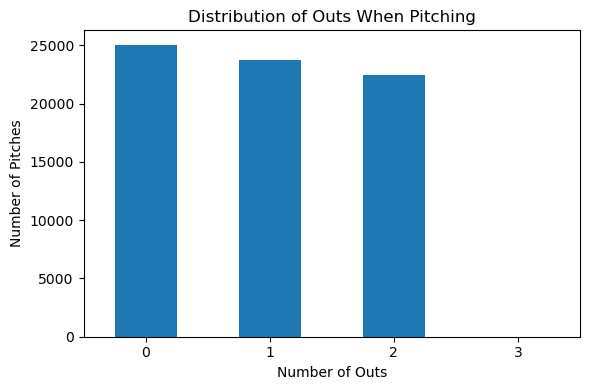

In [35]:
pitch_outs = with_outs.loc[with_outs['play_type'] == 'pitch', 'outs']

outs_counts = pitch_outs.value_counts().sort_index()

outs_pct = outs_counts / outs_counts.sum() * 100

print("Counts of outs at time of pitch:")
print(outs_counts)
print("\nPercentage of outs at time of pitch:")
print(outs_pct.round(2).astype(str) + '%')

plt.figure(figsize=(6,4))
outs_counts.plot(kind='bar')
plt.xlabel('Number of Outs')
plt.ylabel('Number of Pitches')
plt.title('Distribution of Outs When Pitching')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()